<a href="https://colab.research.google.com/github/alex-smith-uwec/NLP_Spring2025/blob/main/StateUnion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from collections import Counter

from datetime import datetime, timedelta

import nltk
from nltk.draw.dispersion import dispersion_plot

In [5]:
# Load the dataset
dataset = load_dataset("jsulz/state-of-the-union-addresses")

# Extract the necessary columns
dates = [item["date"] for item in dataset["train"]]
potus=[item["potus"] for item in dataset["train"]]
texts = [item["lemmatized"] for item in dataset["train"]]

# Combine dates, potus texts, then sort by dates
sorted_data = sorted(zip(dates, potus, texts), key=lambda x: x[0])
sorted_dates, sorted_potus,sorted_texts = zip(*sorted_data)




In [10]:
sorted_dates[0:8]

(Timestamp('1790-01-08 00:00:00'),
 Timestamp('1790-12-08 00:00:00'),
 Timestamp('1791-10-25 00:00:00'),
 Timestamp('1792-11-06 00:00:00'),
 Timestamp('1793-12-03 00:00:00'),
 Timestamp('1794-11-19 00:00:00'),
 Timestamp('1795-12-08 00:00:00'),
 Timestamp('1796-12-07 00:00:00'))

In [26]:

# Initial date for grouping
start_date = pd.Timestamp('1790-01-08')

# Partition sorted_data into 5-year blocks
blocks = []
current_block = []
current_start = start_date
current_end = start_date + pd.DateOffset(years=5)

for date, potus, text in zip(sorted_dates, sorted_potus, sorted_texts):
    if date < current_end:
        current_block.append((date, potus, text))
    else:
        blocks.append(current_block)
        current_block = [(date, potus, text)]
        current_start = current_end
        current_end += pd.DateOffset(years=5)

# Add the last block if it's not empty
if current_block:
    blocks.append(current_block)


# Print the blocks with truncated text
print(f"Number of blocks: {len(blocks)}")
for i, block in enumerate(blocks[:2]):  # Display the first 2 blocks for verification
    print(f"\nBlock {i + 1}:")
    for entry in block:
        date, potus, text = entry
        print(f"  Date: {date}, POTUS: {potus}, Text (truncated): {text[:5]}...")


Number of blocks: 47

Block 1:
  Date: 1790-01-08 00:00:00, POTUS: George Washington, Text (truncated): ['embrace', 'great', 'satisfaction', 'opportunity', 'present']...
  Date: 1790-12-08 00:00:00, POTUS: George Washington, Text (truncated): ['meet', 'feel', 'much', 'satisfaction', 'able']...
  Date: 1791-10-25 00:00:00, POTUS: George Washington, Text (truncated): ['meet', 'upon', 'present', 'occasion', 'feeling']...
  Date: 1792-11-06 00:00:00, POTUS: George Washington, Text (truncated): ['abatement', 'satisfaction', 'meet', 'present', 'occasion']...
  Date: 1793-12-03 00:00:00, POTUS: George Washington, Text (truncated): ['since', 'commencement', 'term', 'call', 'office']...
  Date: 1794-11-19 00:00:00, POTUS: George Washington, Text (truncated): ['call', 'mind', 'gracious', 'indulgence', 'heaven']...

Block 2:
  Date: 1795-12-08 00:00:00, POTUS: George Washington, Text (truncated): ['trust', 'deceive', 'indulge', 'persuasion', 'never']...
  Date: 1796-12-07 00:00:00, POTUS: George 

In [22]:
print(f"Number of blocks: {len(blocks)}")


Number of blocks: 47


In [28]:

# Create a new structure for blocks
processed_blocks = []

for block in blocks:
    # Extract the year from the first entry's date
    block_year = block[0][0].year
    # Merge all text fields into a single list
    merged_text = [word for entry in block for word in entry[2]]  # Flatten all text lists into one list
    # Add to the processed blocks list
    processed_blocks.append({"year": block_year, "texts": merged_text})

# Print the first 2 processed blocks for verification
for i, block in enumerate(processed_blocks[:2]):
    print(f"Block {i + 1} - Year: {block['year']}, Merged Text Length: {len(block['texts'])}")
    print(f"Sample Texts (truncated): {' '.join(block['texts'][:50])}...")  # Join and truncate for readability


Block 1 - Year: 1790, Merged Text Length: 5227
Sample Texts (truncated): embrace great satisfaction opportunity present congratulate present favorable prospect public affair recent accession important state north carolina constitution unite state official information receive rise credit respectability country general increase good toward government union concord peace plenty bless circumstance auspicious eminent degree national prosperity resume consultation general good derive encouragement reflection...
Block 2 - Year: 1795, Merged Text Length: 4945
Sample Texts (truncated): trust deceive indulge persuasion never meet period present situation public affair afford mutual congratulation invite join profound gratitude author good numerous extraordinary blessing enjoy termination long expensive distress war engage certain indian northwest ohio place option united state treaty commander army conclude provisionally hostile tribe region adjustment term satisfaction indian...


In [31]:
# Find the maximum length of merged_text fields
max_length = max(len(block['texts']) for block in processed_blocks)

# Pad each merged_text field with "<OOV>" tokens
for block in processed_blocks:
    current_length = len(block['texts'])
    if current_length < max_length:
        block['texts'].extend(["<OOV>"] * (max_length - current_length))

# Verify padding
for i, block in enumerate(processed_blocks[:2]):  # Display first 2 blocks for verification
    print(f"Block {i + 1} - Year: {block['year']}, Text Length: {len(block['texts'])}")
    print(f"Sample Texts (truncated): {' '.join(block['texts'][:5])}...")
    print(f"Last Tokens: {' '.join(block['texts'][-10:])}")  # Show last 10 tokens to verify padding


Block 1 - Year: 1790, Text Length: 52162
Sample Texts (truncated): embrace great satisfaction opportunity present...
Last Tokens: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
Block 2 - Year: 1795, Text Length: 52162
Sample Texts (truncated): trust deceive indulge persuasion never...
Last Tokens: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>


In [32]:
# Combine all the text into one list
all_words = [word for block in processed_blocks for word in block['texts']]

In [51]:
# Define focus words
focus_words=["liberty","war", "peace","waste","fraud","God","woman","slave","poverty","education","science","technology","computer","intelligence"]

<Figure size 1200x900 with 0 Axes>

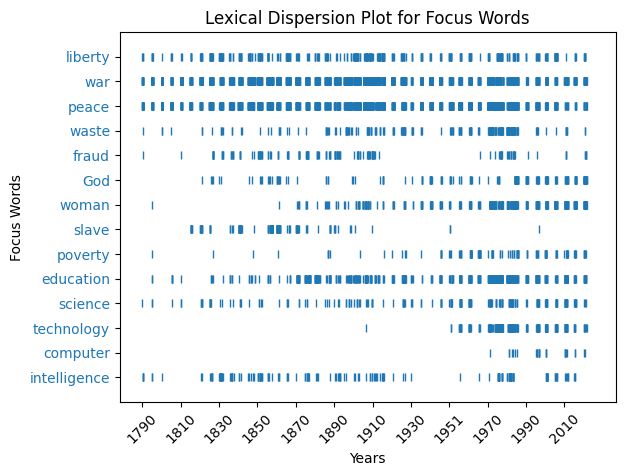

In [52]:


# Generate x-labels for years corresponding to the blocks
years = [block['year'] for block in processed_blocks]
x_ticks_positions = [len(block['texts']) * idx for idx, block in enumerate(processed_blocks)]

# Select  years for x-tick labels thinning
thin=4
x_ticks_positions_filtered = x_ticks_positions[::thin]
x_labels_filtered = years[::thin]

# Dispersion plot with nltk
plt.figure(figsize=(12, 9))
dispersion_plot(all_words, focus_words, ignore_case=True, title="Lexical Dispersion Plot for Focus Words")
plt.xticks(ticks=x_ticks_positions_filtered, labels=x_labels_filtered, rotation=45)
plt.xlabel("Years")
plt.ylabel("Focus Words")
plt.show()




In [53]:
all_words[0:10]

['embrace',
 'great',
 'satisfaction',
 'opportunity',
 'present',
 'congratulate',
 'present',
 'favorable',
 'prospect',
 'public']

In [55]:
# Get the most common words
word_counts = Counter(all_words)

most_common_words = [word for word, freq in word_counts.most_common(10)]  # Adjust '10' for desired number

# Print the most common words
print("Most Common Words:", most_common_words)




Most Common Words: ['<OOV>', 'state', 'government', 'year', 'make', 'congress', 'country', 'people', 'great', 'would']
